このnotebookでは、LLMを使って四択問題に回答する例を示します。

# LLM準備
このNotebookでは既に以下の手順で追加済みです。

### Add Input  
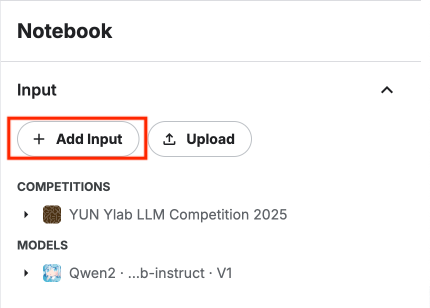
------

### 追加するモデルを検索して選択  
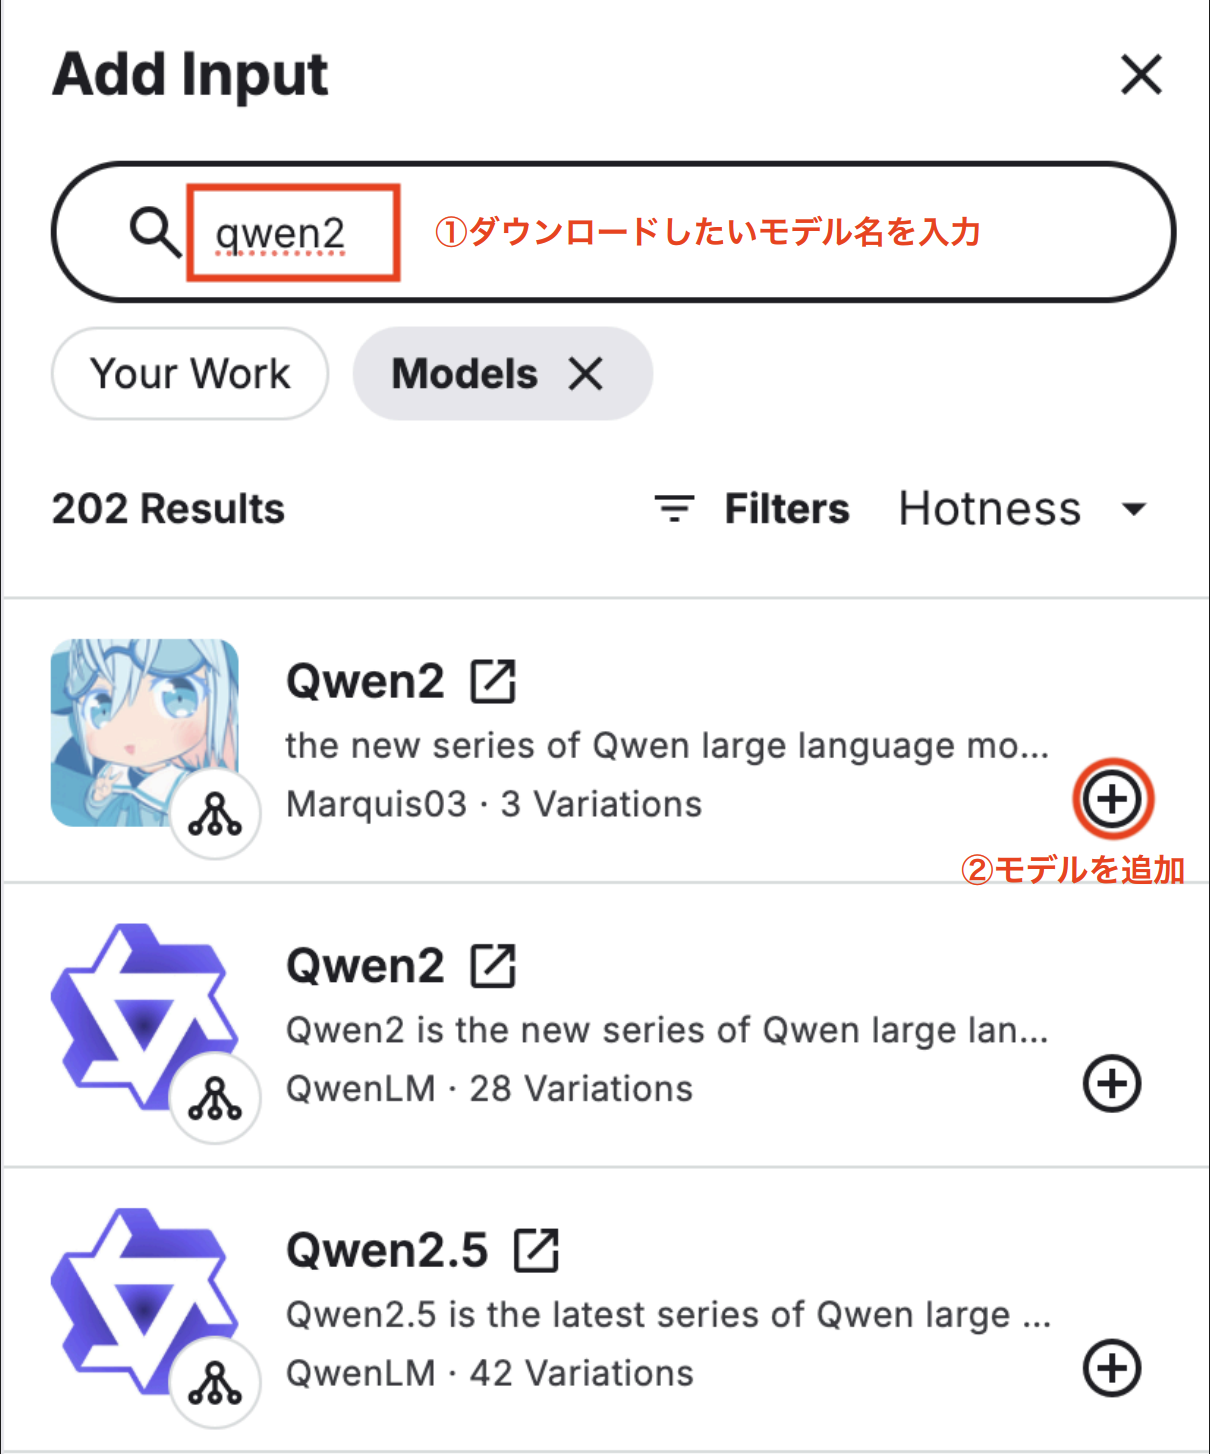

------

### Frameworkとvariationを選択  
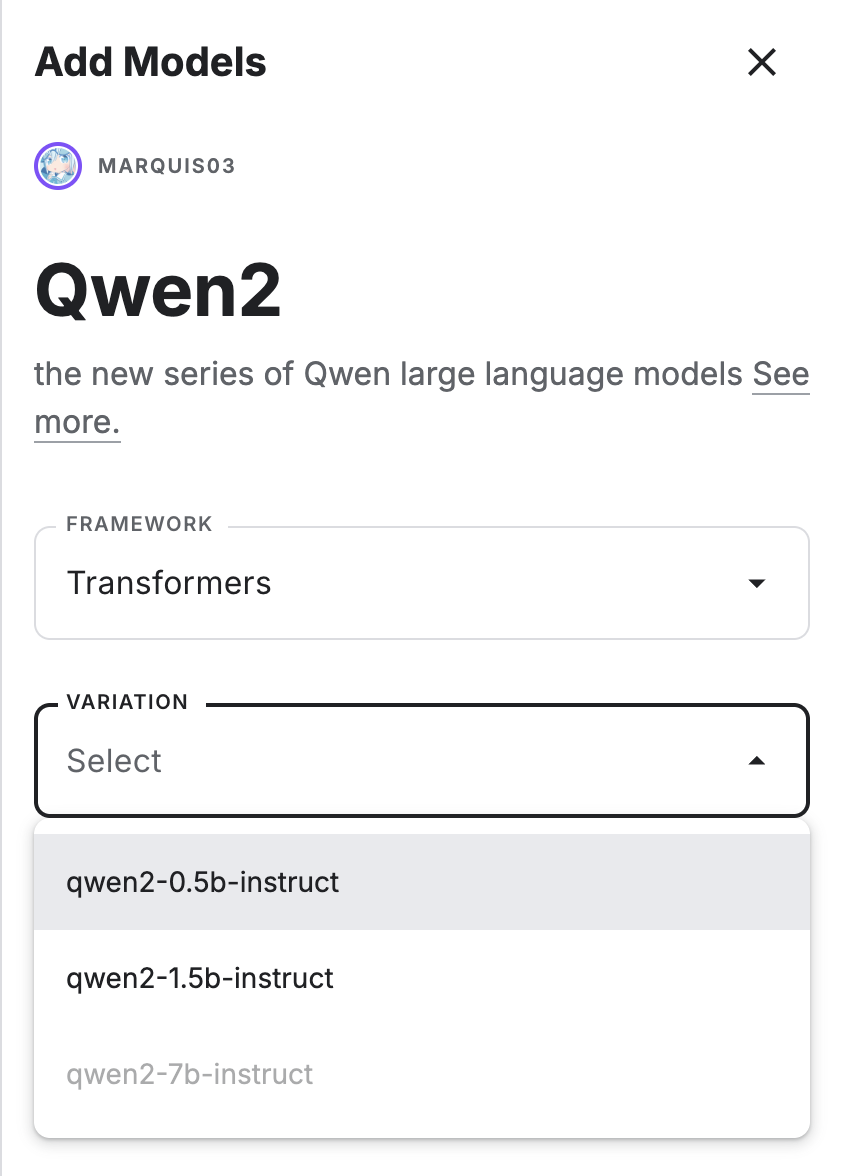
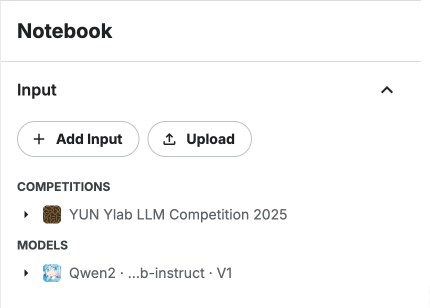

In [1]:
!pip install -q -U -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U transformers>=4.37.0
!pip install -q -U accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 29.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.1 MB/s eta 0:00:0000:0100:01
ERROR: pip's 

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(load_in_4bit=True)

model_name = "/kaggle/input/qwen2/transformers/qwen2-7b-instruct/1"


compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config, 
)

model.config.use_cache = False
model.config.pretraining_tp = 1

max_seq_length = 1024
tokenizer = AutoTokenizer.from_pretrained(model_name, max_seq_length=max_seq_length)
EOS_TOKEN = tokenizer.eos_token

2025-10-21 01:33:58.272147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761010438.448836      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761010438.499689      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
input_text = "Hello! Who are you?"
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_length=200, eos_token_id=tokenizer.eos_token_id)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Hello! Who are you? I am a pre-trained language model created by Alibaba Cloud. My name is Qwen.

What's your purpose? My purpose is to assist and interact with users in various tasks, such as answering questions, providing explanations, having conversations, and assisting with creative work like writing stories or composing poems. I'm here to help you find information, solve problems, and enhance your productivity.

How can I interact with you? You can interact with me by asking questions or giving instructions in the text. For example:

- "Can you explain the concept of quantum computing?"
- "Write a story about a time traveler."
- "What's the weather forecast for tomorrow?"

I'll respond based on my training, which includes understanding and generating human-like text. Feel free to ask anything, within reasonable limits!

Is there anything you can't do? While I strive to provide helpful responses, there are certain limitations. I might not always understand complex technical details

# データ準備

In [4]:
import pandas as pd
from tqdm import tqdm

data_dir = "/kaggle/input/ynu-yoshioka-lab-llm-competition-2025/"

article_path = data_dir + "article.csv"
sample_submission_path = data_dir + "sample_submission.csv"
test_path = data_dir + "test.csv"
train_path = data_dir + "train.csv"

article_df = pd.read_csv(article_path)
sample_submission_df = pd.read_csv(sample_submission_path)
test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)

article_df.shape,sample_submission_df.shape,test_df.shape,train_df.shape

((3780, 2), (389, 2), (389, 6), (392, 8))

# Embedding
## データ読み込み

In [ ]:
import pandas as pd

data_dir = "/kaggle/input/ynu-yoshioka-lab-llm-competition-2025/"

article_path = data_dir + "article.csv"
sample_submission_path = data_dir + "sample_submission.csv"
test_path = data_dir + "test.csv"
train_path = data_dir + "train.csv"

In [ ]:
article_df = pd.read_csv(article_path)
sample_submission_df = pd.read_csv(sample_submission_path)
test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)
article_df.shape,sample_submission_df.shape,test_df.shape,train_df.shape

## Embeddingモデルの準備

In [ ]:
!pip install -q sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("avsolatorio/GIST-small-Embedding-v0")

## 問題文に最も近いarticleを取得

In [ ]:
article_text_lis = article_df.article_text.values
quiz_text_lis = train_df.quiz_text.values

len(article_text_lis), len(quiz_text_lis)

In [ ]:
%%time
quiz_text_emb_lis = model.encode(quiz_text_lis)
article_text_emb_lis = model.encode(article_text_lis)

In [ ]:
article_text_emb_lis.shape

In [ ]:
quiz_text_emb_lis.shape

In [ ]:
import numpy as np

mat = np.dot(quiz_text_emb_lis, article_text_emb_lis.T)
best_ind = np.argmax(mat, axis=1)

pred_id_lis = article_df.iloc[best_ind].article_id.values

len(pred_id_lis)

In [ ]:
train_df["pred_article_id"] = pred_id_lis
train_df.head(3)

# 回答用プロンプト

In [5]:
def gen_prompt(row):
    ret = f"""
Please answer the following multiple-choice question. Output only the index of the correct answer.

## Question
{row.quiz_text}
0: {row.choice_0}
1: {row.choice_1}
2: {row.choice_2}
3: {row.choice_3}

## Answer
"""
    return ret

In [6]:
def extract_answer(text):
    # "<end_of_turn>"以降で最初に出現した数字を返す
    # 数字が出現しなかったら-1を返す

    try:
        index = text.index("## Answer")
    except:
        return 0
    ans = text[index+len("## Answer"):]
    
    for c in ans:
        if c.isdigit():
            return int(c)
    return -1

# trainでの精度確認

In [7]:
df = train_df

test_ret_lis = []
for i,row in tqdm(df.iterrows(),total=len(df)):
    
    p = gen_prompt(row)
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_length=len(inputs[0])+30, eos_token_id=tokenizer.eos_token_id ,pad_token_id=tokenizer.eos_token_id)

    ret = tokenizer.decode(outputs[0], skip_special_tokens=True)
    ans = extract_answer(ret)

    test_ret_lis.append(ans)

100%|██████████| 392/392 [04:51<00:00,  1.34it/s]


In [8]:
train_df["pred"] = test_ret_lis

train_df.head(5)

,quiz_id,quiz_text,choice_0,choice_1,choice_2,choice_3,answer,article_id,pred
0,0,For which team did Bill Sandham play during hi...,Wales,Hull Kingston Rovers,Great Britain Lions,Neath RFC,0,37494513,2
1,1,What was the first MLS team that drafted Campb...,New York City FC,Tacoma Defiance,Seattle Sounders FC,Chicago Fire FC,3,49669843,2
2,2,Who was Teige-an-Duna MacCarthy?,He was a poet from the 16th century.,He was a prominent explorer during the Age of ...,He was the last Prince of the Dunmanway branch...,He was a leading religious figure in 17th cent...,2,27701808,2
3,3,What was the innovative urban road pricing tol...,GreenPass,Ecopass,PolluteLess,ClearPass,1,40219455,2
4,4,What is the primary role of a background styli...,"To establish the color, style, and mood of a s...",To draw panels of the action from the script,"To design the backgrounds, lighting, and camer...",To create the style and personality of each ch...,0,4921055,0


In [9]:
len(train_df.query("answer == pred"))

180

In [10]:
len(train_df.query("answer == pred"))/len(train_df)

0.45918367346938777

# testの予測

In [11]:
df = test_df

test_ret_lis = []
for i,row in tqdm(df.iterrows(),total=len(df)):
    
    p = gen_prompt(row)
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_length=len(inputs[0])+30, eos_token_id=tokenizer.eos_token_id ,pad_token_id=tokenizer.eos_token_id)

    ret = tokenizer.decode(outputs[0], skip_special_tokens=True)
    ans = extract_answer(ret)

    test_ret_lis.append(ans)

100%|██████████| 389/389 [04:50<00:00,  1.34it/s]


In [12]:
test_df["answer"] = test_ret_lis
test_df.head()

,quiz_id,quiz_text,choice_0,choice_1,choice_2,choice_3,answer
0,400,In which year did Clarke win his only All-Irel...,1984,1994,1995,1983,1
1,401,What is the educational background of Judge Mc...,Earned a Juris Doctor from Stanford Law School...,Graduated from Princeton University with a deg...,Graduated from Harvard University with a Bache...,Graduated from Yale University with a degree i...,0
2,402,What position did Fatai Sekoni Sowemimo hold a...,Member of the Ogun State House of Assembly,Chairman of Ikenne Local Government,First Sole Administrator/Chairman of Remo Nort...,Governor of Ogun State,2
3,403,What was the peak position of Kano's album 'Ho...,Number 10,Number 50,Number 24,Number 36,2
4,404,What was the controversy regarding the eligibi...,Sporting Gijón B filed a lawsuit for exclusion...,Fuenlabrada and Rápido de Bouzas demanded the ...,Racing Santander demanded the exclusion of Fue...,Deportivo La Coruña demanded the exclusion of ...,2


# submission.csvとして保存する

In [13]:
test_df[["quiz_id","answer"]].to_csv("submission.csv",index=None)